## Looking at first data from DALEC since continuous deployment started

Just going to take a look at the data to see how it looks and test multilog loading

In [16]:
import pandas as pd
import dalecLoad
import numpy as np
import statistics
import matplotlib.pyplot as plt
import spectralConv
import SD_NC_loading


In [ ]:
def load_DALEC_log(filepath, header=216, dropNA=True, longFormat=True, integerIndex=True, removeSaturated=True):
    """
    loads DALEC log file (excluding spectral wavelength mappings)
    optionally returns log file in long format
    option to convert sample no. index to an integer, or to keep as a string (integerIndex)
    """
    # ideally specify dtype of all rows for efficiency and to prevent bad things
    # need to specify str for lots of columns as these have some rows which contain stuff we need to remove
    DALEC_log = pd.read_csv(filepath,
                            header=header,
                            parse_dates=True,
                            dayfirst=True,
                            infer_datetime_format=True,
                            dtype={'Sample #': str,
                                   ' Lat': str, 
                                   ' Lon': str,
                                   ' Solar Azi': str,
                                   ' Solar Elev': str,
                                   ' Relaz': str,
                                   ' Heading': str,
                                   ' Pitch': str,
                                   ' Roll': str,
                                   ' Gearpos': str,
                                   ' Voltage': str,
                                   ' Temp': str,
                                   'Channel': str,
                                   ' Integration Time': str,
                                   ' Saturation Flag': str,
                                   ' Spec[21]': str,
                                   ' Spec[22]': str,
                                  },
                                   
                            )
    
    # any row with invalid UTC date can be removed
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date'].isna()].index, inplace = True)
    # this removes the duplicated headings
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date'] == 'UTC Date'].index, inplace = True)
    
    if dropNA:
        DALEC_log.dropna(inplace=True, axis=0,)
        
    if longFormat:
        # convert to long format
        # need to test that these variable names always load in this way (leading space on Spec etc.)
        DALEC_log = pd.wide_to_long(DALEC_log, [' Spec['], i=['Sample #', ' Channel'], j='spectral_ind', suffix='\d+]')
        DALEC_log.reset_index(level=2, inplace=True) # remove spectral_ind as an index
        DALEC_log['spectral_ind'] = pd.to_numeric(DALEC_log['spectral_ind'].str[:-1]) # convert spectral_ind to numeric
        DALEC_log.rename(columns={' Spec[': 'Spectral Magnitude'}, inplace=True)
        DALEC_log = DALEC_log.astype({'Spectral Magnitude': 'float64'})
        if integerIndex:
            # change sample no. index to integer
            print('WARNING: some of my old code wont work with integerIndex=True - delete this line once this is sorted')
            idx = DALEC_log.index
            DALEC_log.index = DALEC_log.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])
        # sort index
        DALEC_log.sort_index(inplace=True)
        # change saturation flag to int.
        DALEC_log[' Saturation Flag'] = DALEC_log[' Saturation Flag'].astype(int)
        # format column as datetimes
        DALEC_log[' UTC Date'] = pd.to_datetime(DALEC_log[' UTC Date'], dayfirst=True, infer_datetime_format=True)
        # remove saturated readings - this hasn't been tested on a df which isn't in long format!
        if removeSaturated:
            indSat = DALEC_log[DALEC_log[' Saturation Flag'] == 1].index.get_level_values(0)
            if list(indSat): # checks if the list is empty
                DALEC_log.drop(indSat, level=0, axis=0, inplace=True)

    return DALEC_log


In [ ]:
log71 = dalecLoad.load_DALEC_log('data/Jul-Aug/DALEC_71.dtf', integerIndex=True)

In [ ]:
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/Jul-Aug/DALEC_71.dtf')

In [ ]:
fig, ax = plt.subplots()
for sample in log71.index.get_level_values('Sample #').unique():
        spectra = dalecLoad.uniform_grid_spectra_Rrs(log71.loc[sample],
                                       spect_wavelengths)
        ax.plot(spectra['Wavelength'], (spectra['Rrs']))

In [ ]:
# think this is fine - looks like it works 

def multiLogLoad(filepath, 
                 sep=['DALEC (SN:0005)'],
                 header=216, 
                 dropNA=True,longFormat=True, 
                 integerIndex=True,
                 removeSaturated=True):
    """
    - loads multiple logs which are all contained in a single logfile (eg. that was generated using serial logging of DALEC
    - depending on how the logfile was generated, adjusting 'sep' might allow for different situations...
    - should probably think a bit more about this for a continuous logging application
    """
    # ideally specify dtype of all rows for efficiency and to prevent bad things - TODO!
    # need to specify str for lots of columns as these have some rows which contain stuff we need to remove
    col_names = pd.read_csv(filepath, nrows=0, header=header,).columns
    types_dict = {} # if I want to be more specific then I can specify any cols which I don't want to be str
    types_dict.update({col: str for col in col_names if col not in types_dict})
    types_dict.pop(' UTC Date', ' UTC Time') # want these to be formatted as datetime by pd.read_csv
    
    df = pd.read_csv(filepath,
                     header=header,
                     parse_dates=True,
                     dayfirst=True,
                     infer_datetime_format=True,
                     dtype=types_dict,
                     )
    
    groups = df['Sample #'].isin(sep).cumsum()
    names = ['Log ' + str(i) for i in range(len(set(groups)))] 
    tables = {name: g[1].iloc[1:] for g,name in zip(df.groupby(groups), names)} 
    # because we've used 'DALEC (SN:0005)' as the way to seperate logfiles, we need to remove the first lines before this
    # if a different sep is used, then this line may no longer work... so perhaps need to make this more robust!
    tables.pop('Log 0')
    print(len(tables))
    for name, table in tables.items():
        # any row with invalid UTC date can be removed
        table.drop(table[table[' UTC Date'].isna()].index, inplace = True)
        # this removes the duplicated headings
        table.drop(table[table[' UTC Date'] == 'UTC Date'].index, inplace = True)
        if dropNA:
            table.dropna(inplace=True, axis=0,)
        if longFormat:
            # convert to long format
            # need to test that these variable names always load in this way (leading space on Spec etc.)
            table = pd.wide_to_long(table, [' Spec['], i=['Sample #', ' Channel'], j='spectral_ind', suffix='\d+]')
            table.reset_index(level=2, inplace=True) # remove spectral_ind as an index
            table['spectral_ind'] = pd.to_numeric(table['spectral_ind'].str[:-1]) # convert spectral_ind to numeric
            table.rename(columns={' Spec[': 'Spectral Magnitude'}, inplace=True)
            table = table.astype({'Spectral Magnitude': 'float64'})
        if integerIndex:
            # change sample no. index to integer
            print('WARNING: some of my old code wont work with integerIndex=True - delete this line once this is sorted')
            idx = table.index
            table.index = table.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])
        # sort index
        table.sort_index(inplace=True)
        # change saturation flag to int.
        table[' Saturation Flag'] = table[' Saturation Flag'].astype(int)
        # format column as datetimes
        table[' UTC Date'] = pd.to_datetime(table[' UTC Date'], dayfirst=True, infer_datetime_format=True)
        # remove saturated readings - this hasn't been tested on a df which isn't in long format!
        if removeSaturated:
            indSat = table[table[' Saturation Flag'] == 1].index.get_level_values(0)
            if list(indSat): # checks if the list is empty
                table.drop(indSat, level=0, axis=0, inplace=True)
        
        tables[name] = table
    return tables

In [ ]:
# my current understanding is that multiLogLoad works if we use 'Sample #' as the sep AND we accept that data which came in
# from the serial port might be missing lines. So far this has resulted in a TypeError, but could give other errors I think...
# good to keep an eye on this to find out if other types of errors occur

tables = dalecLoad.multiLogLoad('data/Jul-Aug/DALEC_72_73.dtf', sep=['Sample #'])

In [ ]:
tables['Log 2']

In [ ]:
# the TRY PASS thing works nicely for plotting! 

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
for i in range(len(tables)):
    ind = list(tables.keys())[i]
    for sample in tables[ind].index.get_level_values('Sample #').unique():
        try:
            spectra = dalecLoad.uniform_grid_spectra_Rrs(tables[ind].loc[sample],
                                               spect_wavelengths)
            ax[i].plot(spectra['Wavelength'], (spectra['Rrs']), color='b', alpha=0.05)
        except KeyError:
            # worth investigating more if there ever seems to be a very large number of KeyErrors
            print('KeyError')
            pass

In [ ]:
np.array(tables['Log 1'].index.values)

for i in range(3613, 7247):
    print(i)
    tables['Log 1'].loc[i, 'Lsky']
    # so this breaks at sample number = 6224

In [ ]:
tables['Log 1'].loc[6224, :].shape
# okay so this only has 400 rows, and each channel should have 200 wavelengths on it, so we expect 600!

# when inspecting the log file, I find that there is a line missing at 6224!
# this means my code is fine, but the serial data failed to read this line for some reason.
# so, probably just skip this sample? - can use try except

In [ ]:
for i in range(6225, 7248):
    print(i)
    tables['Log 1'].loc[i, 'Lsky']
    # this doesn't break! 

In [7]:
# interested to see what happens if we load a multiLog with normal dalecLoad:

# I've now messed with this significantly that I think it will probably break a load of other stuff
# if I just go ahead and plonk this into dalecLoad.py
# might be a good time to make a branch so that I can test dalecLoad.py without worrying about breaking everything

def load_DALEC_log(filepath, header=216, dropNA=True, longFormat=True, integerIndex=True,
                   removeSaturated=True, parse_dates=[[' UTC Date', ' UTC Time']]):
    """
    loads DALEC log file (excluding spectral wavelength mappings)
    optionally returns log file in long format
    option to convert sample no. index to an integer, or to keep as a string (integerIndex)
    """
    # ideally specify dtype of all rows for efficiency and to prevent bad things - TODO!
    # need to specify str for lots of columns as these have some rows which contain stuff we need to remove
    DALEC_log = pd.read_csv(filepath,
                            header=header,
                            parse_dates=parse_dates,
                            dayfirst=True,
                            infer_datetime_format=True,
                            dtype={'Sample #': str,
                                   ' Lat': str, 
                                   ' Lon': str,
                                   ' Solar Azi': str,
                                   ' Solar Elev': str,
                                   ' Relaz': str,
                                   ' Heading': str,
                                   ' Pitch': str,
                                   ' Roll': str,
                                   ' Gearpos': str,
                                   ' Voltage': str,
                                   ' Temp': str,
                                   'Channel': str,
                                   ' Integration Time': str,
                                   ' Saturation Flag': str,
                                   ' Spec[21]': str,
                                   ' Spec[22]': str,
                                  },
                            )
    
    # any row with invalid UTC date can be removed
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date_ UTC Time'].isna()].index, inplace = True)
    # this removes the duplicated headings
    DALEC_log.drop(DALEC_log[DALEC_log[' UTC Date_ UTC Time'] == ' UTC Date_ UTC Time'].index, inplace = True)
    
    if dropNA:
        DALEC_log.dropna(inplace=True, axis=0,)
        
    if longFormat:
        # convert to long format
        # need to test that these variable names always load in this way (leading space on Spec etc.)
        DALEC_log = pd.wide_to_long(DALEC_log, [' Spec['], i=['Sample #', ' Channel'], j='spectral_ind', suffix='\d+]')
        DALEC_log.reset_index(level=2, inplace=True) # remove spectral_ind as an index
        DALEC_log['spectral_ind'] = pd.to_numeric(DALEC_log['spectral_ind'].str[:-1]) # convert spectral_ind to numeric
        DALEC_log.rename(columns={' Spec[': 'Spectral Magnitude'}, inplace=True)
        DALEC_log = DALEC_log.astype({'Spectral Magnitude': 'float64'})
        if integerIndex:
            # change sample no. index to integer
            print('WARNING: some of my old code wont work with integerIndex=True - delete this line once this is sorted')
            idx = DALEC_log.index
            DALEC_log.index = DALEC_log.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])
        # sort index
        DALEC_log.sort_index(inplace=True)
        # change saturation flag to int.
        DALEC_log[' Saturation Flag'] = DALEC_log[' Saturation Flag'].astype(int)
        # format column as datetimes
        DALEC_log[' UTC Date_ UTC Time'] = pd.to_datetime(DALEC_log[' UTC Date_ UTC Time'], dayfirst=True, infer_datetime_format=True)
        # remove saturated readings - this hasn't been tested on a df which isn't in long format!
        if removeSaturated:
            indSat = DALEC_log[DALEC_log[' Saturation Flag'] == 1].index.get_level_values(0)
            if list(indSat): # checks if the list is empty
                DALEC_log.drop(indSat, level=0, axis=0, inplace=True)
    DALEC_log.set_index(['spectral_ind', ' UTC Date_ UTC Time'], drop=True, append=True, inplace=True)
    
    # let's sort out these stupid names and remove leading spaces
    rename_cols_dict = dict([(col, col[1:]) for col in DALEC_log.columns[1:-1]])

    DALEC_log.rename(columns=rename_cols_dict, inplace=True)
    DALEC_log.index.rename(['Sample #', 'Channel', 'spectral_ind', 'Datetime'], inplace=True)
    
    # don't need sample no. as an index I don't think
    DALEC_log.index = DALEC_log.index.droplevel('Sample #')

    return DALEC_log

multiLog = load_DALEC_log('data/Jul-Aug/DALEC_72_73.dtf')
multiLog

Pitch Solar Elev Solar Azi  \
Channel spectral_ind Datetime                                              
Ed      21           2022-07-29 10:00:04.150    1.0       44.1     130.0   
        22           2022-07-29 10:00:04.150    1.0       44.1     130.0   
        23           2022-07-29 10:00:04.150    1.0       44.1     130.0   
        24           2022-07-29 10:00:04.150    1.0       44.1     130.0   
        25           2022-07-29 10:00:04.150    1.0       44.1     130.0   
...                                             ...        ...       ...   
Lu      216          2022-07-30 11:59:58.886    0.0       52.1     171.4   
        217          2022-07-30 11:59:58.886    0.0       52.1     171.4   
        218          2022-07-30 11:59:58.886    0.0       52.1     171.4   
        219          2022-07-30 11:59:58.886    0.0       52.1     171.4   
        220          2022-07-30 11:59:58.886    0.0       52.1     171.4   

                                              Roll          Lon  \
Channel spectral_ind Datetime                                     
Ed      21           2022-07-29 10:00:04.150   0.0  -3.92305679   
        22           2022-07-29 10:00:04.150   0.0  -3.92305679   
        23           2022-07-29 10:00:04.150   0.0  -3.92305679   
        24           2022-07-29 10:00:04.150   0.0  -3.92305679   
        25           2022-07-29 10:00:04.150   0.0  -3.92305679   
...                                            ...          ...   
Lu      216          2022-07-30 11:59:58.886  -2.0  -3.92305679   
        217          2022-07-30 11:59:58.886  -2.0  -3.92305679   
        218          2022-07-30 11:59:58.886  -2.0  -3.92305679   
        219          2022-07-30 11:59:58.886  -2.0  -3.92305679   
        220          2022-07-30 11:59:58.886  -2.0  -3.92305679   

                                              Saturation Flag         Lat  \
Channel spectral_ind Datetime                                               
Ed      21           2022-07-29 10:00:04.150                0  56.1468505   
        22           2022-07-29 10:00:04.150                0  56.1468505   
        23           2022-07-29 10:00:04.150                0  56.1468505   
        24           2022-07-29 10:00:04.150                0  56.1468505   
        25           2022-07-29 10:00:04.150                0  56.1468505   
...                                                       ...         ...   
Lu      216          2022-07-30 11:59:58.886                0  56.1468505   
        217          2022-07-30 11:59:58.886                0  56.1468505   
        218          2022-07-30 11:59:58.886                0  56.1468505   
        219          2022-07-30 11:59:58.886                0  56.1468505   
        220          2022-07-30 11:59:58.886                0  56.1468505   

                                             GPS_Fix     Temp Gearpos Voltage  \
Channel spectral_ind Datetime                                                   
Ed      21           2022-07-29 10:00:04.150       F  33.3125   -60.1    11.6   
        22           2022-07-29 10:00:04.150       F  33.3125   -60.1    11.6   
        23           2022-07-29 10:00:04.150       F  33.3125   -60.1    11.6   
        24           2022-07-29 10:00:04.150       F  33.3125   -60.1    11.6   
        25           2022-07-29 10:00:04.150       F  33.3125   -60.1    11.6   
...                                              ...      ...     ...     ...   
Lu      216          2022-07-30 11:59:58.886       F   29.375   -57.3    11.6   
        217          2022-07-30 11:59:58.886       F   29.375   -57.3    11.6   
        218          2022-07-30 11:59:58.886       F   29.375   -57.3    11.6   
        219          2022-07-30 11:59:58.886       F   29.375   -57.3    11.6   
        220          2022-07-30 11:59:58.886       F   29.375   -57.3    11.6   

                                               Relaz Integration Time Heading  \
Channel spectral_ind Datetime                   

In [8]:
# okay this is the stuff I've been wanting 

level_values = multiLog.index.get_level_values
result = (multiLog.groupby(['Channel', 'spectral_ind']
                           +[pd.Grouper(freq='1D', level='Datetime')]).mean())

In [9]:
result

Saturation Flag  Spectral Magnitude
Channel spectral_ind Datetime                                       
Ed      21           2022-07-29              0.0            0.341578
                     2022-07-30              0.0            0.317864
        22           2022-07-29              0.0            0.350649
                     2022-07-30              0.0            0.324495
        23           2022-07-29              0.0            0.348269
...                                          ...                 ...
Lu      218          2022-07-30              0.0            0.001177
        219          2022-07-29              0.0            0.000526
                     2022-07-30              0.0            0.001128
        220          2022-07-29              0.0            0.000547
                     2022-07-30              0.0            0.001133

[1200 rows x 2 columns]

In [10]:
def uniform_grid_spectra_mean(DALEC_log, spect_wavelengths, RHO=0.028, nsteps=601, min_waveL=400, max_waveL=1000):
    """
    - takes mean spectrum from an entire DALEC log file and converts to a uniform grid
    - grid is defined by nsteps, min_waveL and max_waveL
    - returns a pandas DF with Lu_mean, Lsky_mean and Ed_mean
    """
    # this is a much more optimal way than previously! - 
    df = DALEC_log.copy() # not sure if neccesary but perhaps best to be on the safe side?
    # setting spectral_ind as an index might be useful for other stuff too?
    df.set_index('spectral_ind', append=True, inplace=True)
    df = df.groupby(level=['Channel', 'spectral_ind']).mean(numeric_only=True)
    Lu_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lu', nsteps=nsteps)
    Lsky_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lsky', nsteps=nsteps)
    Ed_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Ed', nsteps=nsteps)
    
    Rrs_mean = (Lu_mean[:, 1] - (RHO * Lsky_mean[:, 1])) / Ed_mean[:, 1]
    
    df_out = pd.DataFrame(data={'Wavelength': Lu_mean[:, 0],
                               'Lu_mean': Lu_mean[:, 1], 
                               'Lsky_mean': Lsky_mean[:, 1],
                               'Ed_mean': Ed_mean[:, 1],
                               'Rrs_mean': Rrs_mean})
    return df_out


In [11]:

spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/Jul-Aug/DALEC_72_73.dtf')

def uniform_grid_spectra_multi(DALEC_log, spect_wavelengths, RHO=0.028, nsteps=601, min_waveL=400, max_waveL=1000,
                               resample_to_SDs=True, DALEC_col_name='DALEC_mean_Rrs'):
    df_out = None
    if resample_to_SDs:
        RSR_doves_file='non-DALEC-data/RSR-Superdove.csv'
        RSR_doves = pd.read_csv(RSR_doves_file)
        doves_wavelengths = [444., 492., 533., 566., 612., 666., 707., 866.]

        
    for date in DALEC_log.index.get_level_values('Datetime').unique():
        df = DALEC_log.loc[:, :, [date]]
        Lu_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lu', nsteps=nsteps)
        Lsky_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Lsky', nsteps=nsteps)
        Ed_mean = dalecLoad.uniform_grid_spectra(df, spect_wavelengths, param='Ed', nsteps=nsteps)
        Rrs_mean = (Lu_mean[:, 1] - (RHO * Lsky_mean[:, 1])) / Ed_mean[:, 1]
        
        if resample_to_SDs:
            DALEC_SD = spectralConv.SD_band_calc(RSR_doves, Rrs_mean,
                                                 RSR_doves['Wavelength (nm)'].values)

            df_tmp = pd.DataFrame(data=DALEC_SD, columns=[DALEC_col_name])
            df_tmp['Date'] = np.full((8,), date)
            df_tmp['Wavelength'] = doves_wavelengths
            df_tmp.set_index(['Date', 'Wavelength'], inplace=True)

        else:
            df_tmp = pd.DataFrame(index=np.full((nsteps,), date),
                                  data={'Wavelength': Lu_mean[:, 0],
                                        'Lu_mean': Lu_mean[:, 1], 
                                        'Lsky_mean': Lsky_mean[:, 1],
                                        'Ed_mean': Ed_mean[:, 1],
                                        'Rrs_mean': Rrs_mean})
            df_tmp.index.rename('Date', inplace=True)
            df_tmp.set_index('Wavelength', append=True, inplace=True)
            
        if df_out is None:
            df_out = df_tmp.copy()
        else:
            df_out = pd.concat([df_out, df_tmp])
    
    
    


    return df_out

df_daily_gridded = uniform_grid_spectra_multi(result, spect_wavelengths, resample_to_SDs=True)
df_daily_gridded

DALEC_mean_Rrs
Date       Wavelength                
2022-07-29 444.0             0.002506
           492.0             0.003984
           533.0             0.006848
           566.0             0.008317
           612.0             0.006328
           666.0             0.004525
           707.0             0.006690
           866.0             0.000702
2022-07-30 444.0             0.002311
           492.0             0.004045
           533.0             0.007353
           566.0             0.008979
           612.0             0.006776
           666.0             0.004795
           707.0             0.007589
           866.0             0.000259

In [12]:
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/Jul-Aug/DALEC_72_73.dtf')

# okay so with these new versions of the loading functions I can load a multilog file generated from serial output
multiLog = load_DALEC_log('data/Jul-Aug/DALEC_72_73.dtf')
# and then take daily (or another time interval) means
result = (multiLog.groupby(['Channel', 'spectral_ind']
                           +[pd.Grouper(freq='1D', level='Datetime')]).mean())
# and finally regrid, calc Rrs, and resample to SD wavelengths
df_daily_gridded = uniform_grid_spectra_multi(result, spect_wavelengths, resample_to_SDs=True)
df_daily_gridded

DALEC_mean_Rrs
Date       Wavelength                
2022-07-29 444.0             0.002506
           492.0             0.003984
           533.0             0.006848
           566.0             0.008317
           612.0             0.006328
           666.0             0.004525
           707.0             0.006690
           866.0             0.000702
2022-07-30 444.0             0.002311
           492.0             0.004045
           533.0             0.007353
           566.0             0.008979
           612.0             0.006776
           666.0             0.004795
           707.0             0.007589
           866.0             0.000259

In [18]:
# let's try 20 min mean:
result_hourly = (multiLog.groupby(['Channel', 'spectral_ind']
                           +[pd.Grouper(freq='10min', level='Datetime')]).mean())
# and finally regrid, calc Rrs, and resample to SD wavelengths
df_hourly_gridded = uniform_grid_spectra_multi(result_hourly, spect_wavelengths, resample_to_SDs=True)
df_hourly_gridded

DALEC_mean_Rrs
Date                Wavelength                
2022-07-29 10:00:00 444.0             0.002098
                    492.0             0.003592
                    533.0             0.006378
                    566.0             0.007787
                    612.0             0.005889
...                                        ...
2022-07-30 11:50:00 566.0             0.007579
                    612.0             0.005708
                    666.0             0.004012
                    707.0             0.006368
                    866.0             0.000240

[192 rows x 1 columns]

In [19]:
result_hourly

Saturation Flag  Spectral Magnitude
Channel spectral_ind Datetime                                                
Ed      21           2022-07-29 10:00:00              0.0            0.324635
                     2022-07-29 10:10:00              0.0            0.371567
                     2022-07-29 10:20:00              0.0            0.205227
                     2022-07-29 10:30:00              0.0            0.321153
                     2022-07-29 10:40:00              0.0            0.365285
...                                                   ...                 ...
Lu      220          2022-07-30 11:10:00              0.0            0.001228
                     2022-07-30 11:20:00              0.0            0.001165
                     2022-07-30 11:30:00              0.0            0.001251
                     2022-07-30 11:40:00              0.0            0.000893
                     2022-07-30 11:50:00              0.0            0.001142

[14400 rows x 2 columns]

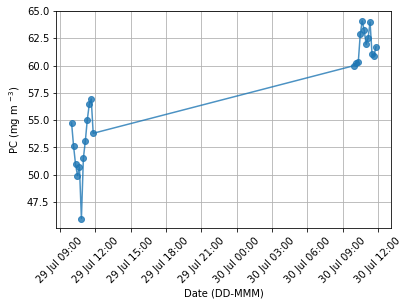

<AxesSubplot:xlabel='Date (DD-MMM)', ylabel='PC (mg m $^{-3}$)'>

In [20]:
SD_NC_loading.plot_algorithm_from_DF(df_hourly_gridded,
                                     algorithm=SD_NC_loading.NDPCI_from_DF,
                                     dailyTicks=False, date_format='%d %b %H:%M')

In [ ]:
# nice. Now need to integrate all dis stuff with my other shit
# would be particularly nice to be able to load all DALEC logs in a folder with a mix of single and multilogs....